In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import preliz as pz
import pymc as pm

In [2]:
az.style.use("arviz-white")
plt.rcParams["figure.dpi"] = 300

In [3]:
bikes = pd.read_csv("bikes.csv")
y = bikes["count"].values
X = bikes[["hour"]].values
bikes.head()

,count,hour,temperature,humidity,windspeed
0,16,0,0.24,0.81,0.0000
1,3,5,0.16,0.47,0.2836
2,115,9,0.22,0.37,0.3284
3,73,13,0.20,0.37,0.2836
4,82,15,0.22,0.35,0.3582


In [4]:
def get_ig_params(x_vals, l_b=None, u_b=None, mass=0.95, plot=False):
    """
    Returns a weakly informative prior for the length-scale parameter of the GP kernel.
    """

    differences = np.abs(np.subtract.outer(x_vals, x_vals))
    if l_b is None:
        l_b = np.min(differences[differences != 0]) * 2
    if u_b is None:
        u_b = np.max(differences) / 1.5

    dist = pz.InverseGamma()
    pz.maxent(dist, l_b, u_b, mass, plot=plot)

    return dict(zip(dist.param_names, dist.params))


for x in bikes[["hour", "temperature", "humidity", "windspeed"]].values.T:
    params = get_ig_params(x)
    l_hdi = pz.InverseGamma(**params).hdi(mass=0.99)
    S = (x.max() - x.min()) / 2
    c = 1.5
    m = np.mean([1.75 * c / (L / S) for L in l_hdi])
    print("InverseGamma", params, "m", m)

/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
/home/pablo/anaconda3/envs/bart-experiments/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2168: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


InverseGamma {'alpha': 5.054174140477293, 'beta': 30.59906930193435} m 8.889691891100702
InverseGamma {'alpha': 4.243939821476508, 'beta': 0.8653266455515541} m 11.894354838709678
InverseGamma {'alpha': 4.241562936429315, 'beta': 0.824315695773419} m 11.367134831460675
InverseGamma {'alpha': 4.285856418715763, 'beta': 0.5341991089701256} m 12.0396875


In [5]:
with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma("ℓ", alpha=5, beta=30)

    cov = pm.gp.cov.ExpQuad(1, ls=ℓ)
    gp = pm.gp.HSGP(m=[10], c=1.5, cov_func=cov)

    f = gp.prior("f", X=X)
    α = pm.HalfNormal("α", 1)
    pm.NegativeBinomial("obs", np.exp(f), α, observed=y)

    idata_hsgp = pm.sample(chains=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [ℓ, f_hsgp_coeffs_, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


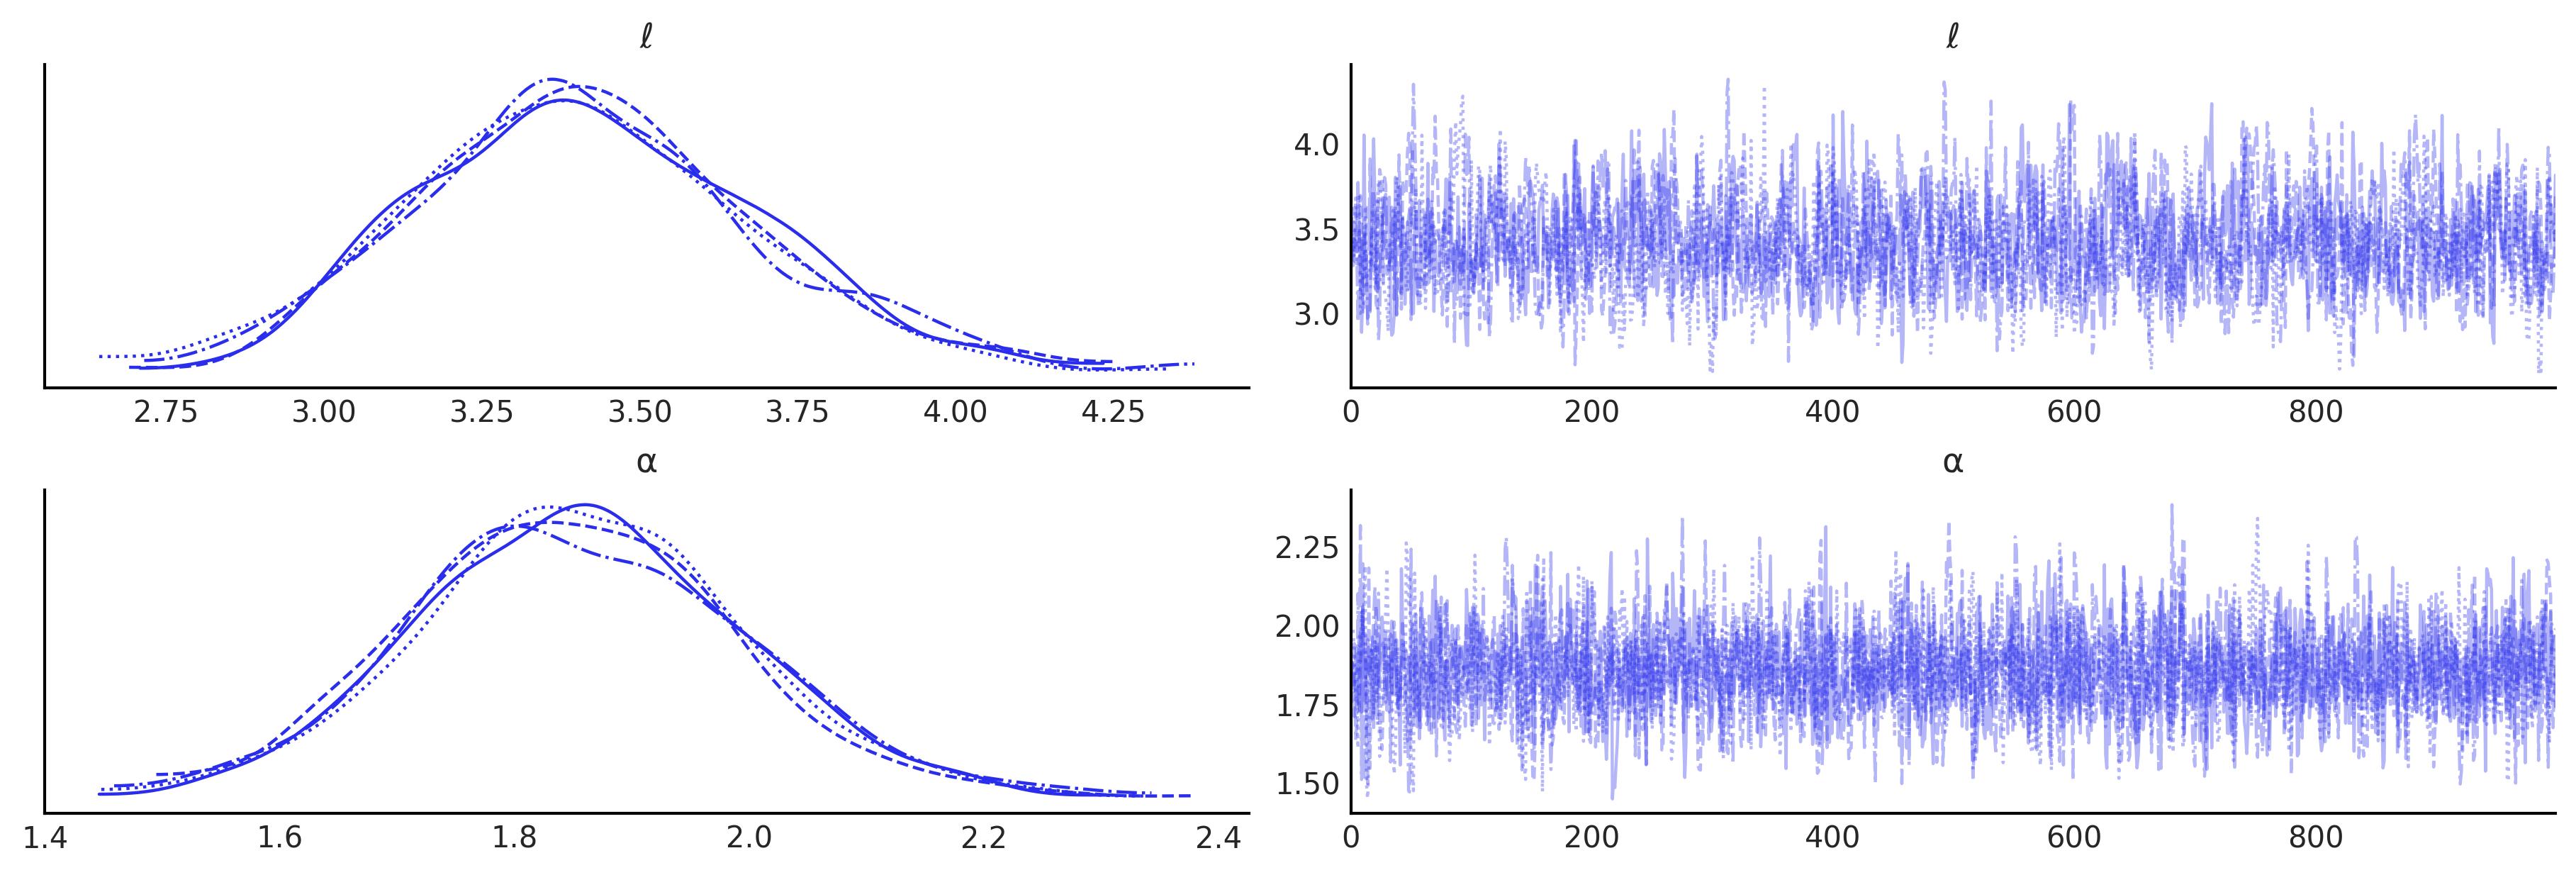

In [6]:
az.plot_trace(idata_hsgp, var_names=["ℓ", "α"]);

## With 2 covariates

In [7]:
y = bikes["count"].values
X = bikes[["hour", "temperature"]].values

In [8]:
with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma("ℓ", alpha=[5] * 2, beta=[30, 0.9], shape=2)

    cov = pm.gp.cov.ExpQuad(2, ls=ℓ)
    gp = pm.gp.HSGP(m=[10] * 2, c=1.5, cov_func=cov)

    f = gp.prior("f", X=X)
    α = pm.HalfNormal("α", 1)
    pm.NegativeBinomial("obs", np.exp(f), α, observed=y)

    idata_hsgp = pm.sample(chains=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [ℓ, f_hsgp_coeffs_, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 122 seconds.


## With 3 covariates

In [9]:
y = bikes["count"].values
X = bikes[["hour", "temperature", "humidity"]].values

In [10]:
with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma("ℓ", alpha=[5] * 3, beta=[30, 0.9, 0.8], shape=3)

    cov = pm.gp.cov.ExpQuad(3, ls=ℓ)
    gp = pm.gp.HSGP(m=[10] * 3, c=1.5, cov_func=cov)

    f = gp.prior("f", X=X)
    α = pm.HalfNormal("α", 1)
    pm.NegativeBinomial("obs", np.exp(f), α, observed=y)

    idata_hsgp = pm.sample(chains=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [ℓ, f_hsgp_coeffs_, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 256 seconds.


## With 4 covariates  

In [11]:
y = bikes["count"].values
X = bikes[["hour", "temperature", "humidity", "windspeed"]].values

with pm.Model() as model_hsgp:
    ℓ = pm.InverseGamma("ℓ", alpha=[5] * 4, beta=[30, 0.9, 0.8, 0.5], shape=4)

    cov = pm.gp.cov.ExpQuad(4, ls=ℓ)
    gp = pm.gp.HSGP(m=[10] * 4, c=1.5, cov_func=cov)

    f = gp.prior("f", X=X)
    α = pm.HalfNormal("α", 1)
    pm.NegativeBinomial("obs", np.exp(f), α, observed=y)

    idata_hsgp = pm.sample(chains=4, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [ℓ, f_hsgp_coeffs_, α]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1530 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
